<a href="https://colab.research.google.com/github/lucagnecchi/NER_project/blob/main/MyProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from IPython.display import HTML

html_code = """
<!DOCTYPE html>
<html>
<head>
    <style>
        /* Il tuo stile CSS qui */
    </style>
</head>
<body>
    <div class="banner" style="color: white; background: linear-gradient(90deg, rgba(131,58,180,1) 0%, rgba(253,29,29,1) 50%, rgba(252,176,69,1) 100%);">
        <div class="text" style="padding: 50px 30px 50px 30px; text-align: center;">
            <span style="font-size: 24pt; font-family: 'courier new', courier, monospace;"><strong>Data Visualization</strong> and <strong>Text Mining</strong> project</span>
        </div>
    </div>
</body>
</html>
"""

HTML(html_code)


# Introduction

*Anatomical entities* are central to much of biomedical scientific discourse, the **AnEM corpus** is a dataset that can be used for the detection of *anatomical entities* in the text. The **AnEM corpus** was created by the *NaCTeM* (National Center for Text Mining). The corpus contains over 90000 words from 500 documents selected randomly from abstracts and full-text papers that are representative of the biomedical scientific literature.
The **goal** of this project is to perform Named entity extraction on the corpus by using different machine learning architectures. The models will try to associate each word of the corpus with the correct tag.

## File format

The corpus is stored in IOB2 format, a common tagging format for performing the *Name Entity Recognition* task. This is a standard format promoted by the **CoNLL (Conference on Computational Natural
Language Learning)**. The *O* tag means that the token belongs to no chunks while the *B* tag is used at the beginning of every chunk and the *I* prefix indicates that a token is inside a chunk. In the table below are displayed all the labels used in this corpus.

<table>
<thead>
<tr>
<th>Labels</th>
</tr>
</thead>
<tbody>
<tr>
<td>Anatomical_system</td>
</tr>
<tr>
<td>Cell</td>
</tr>
<tr>
<td>Cellular_component</td>
</tr>
<tr>
<td>Developing_anatomical_structure</td>
</tr>
<tr>
<td>Immaterial_anatomical_entity</td>
</tr>
<tr>
<td>Multi-tissue_structure</td>
</tr>
<tr>
<td>Organ</td>
</tr>
<tr>
<td>Organism_subdivision</td>
</tr>
<tr>
<td>Organism_substance</td>
</tr>
<tr>
<td>Pathological_formation</td>
</tr>
<tr>
<td>Tissue</td>
</tr>
</tbody>
</table>

## Loading libraries

In [ ]:
!pip install seqeval
!python -m spacy download en_core_web_lg
!pip install tensorflow_addons
!pip install dash
!pip install dash_bootstrap_components
!pip install dash_core_components
!pip install dash_html_components

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 937.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=abf0c012c6bdc6168d11e0374f24f23a1ab1566a97d837dddb56df43a680dad5
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
2023-12-21 12:18:34.452333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 12:18:34.459457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 12:18:34.462342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
import plotly.graph_objects as go
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import urllib
import sklearn
import logging
import os
import tensorflow as tf
from seqeval.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import re
import io
import requests
from io import BytesIO
from wordcloud import WordCloud
from PIL import Image
import random
import time
import numpy as np
from math import nan
import spacy
import ipywidgets as widgets
from IPython.display import display, clear_output
from spacy.tokens import Doc, Span
from spacy import displacy
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow_addons.layers import CRF
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from keras.models import save_model, load_model
from plotly.subplots import make_subplots
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
<ipython-input-2-69f1ca22874b>:46: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-2-69f1ca22874b>:47: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


## Data exploration

In [ ]:
train = "https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/AnEM.train"
test = "https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/AnEM.test"
df_train = pd.read_csv(train, sep='\t', header = None)
df_test = pd.read_csv(test, sep='\t', header = None)
df = pd.concat((df_train, df_test))
df.columns = ["word","start","end","ner_tag"]
df.head(10)


,word,start,end,ner_tag
0,Ventricular,0,11,B-Multi-tissue_structure
1,fibrillation,12,24,O
2,due,25,28,O
3,to,29,31,O
4,long,32,36,O
5,QT,37,39,O
6,syndrome,40,48,O
7,probably,49,57,O
8,caused,58,64,O
9,by,65,67,O


As we can see from the first 10 rows of the database, we have that the dataset has 4 columns:
- word: single word of the corpus
- start: begin character position
- end: end character position
- ner_tag: classification label

In [ ]:
df = df.where(df["ner_tag"]!="O").dropna()

In [ ]:
cat_df=Counter(df["ner_tag"])
df["ner_tag_cat"]=df["ner_tag"].map(cat_df)

Checking for missing values.

In [ ]:
df.isnull().sum()

word           0
start          0
end            0
ner_tag        0
ner_tag_cat    0
dtype: int64

### Utilities functions for IOB

Since we are dealing with IOB format, we have to define some functions in order to manipulate this type of file.

In [ ]:
CONLL_URL_ROOT = "https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/"

def open_read_from_url(url):
    """
    Take in input an url to a .txt file and return the list of its rows
    """
    print(f"Read file from {url}")
    file = urllib.request.urlopen(url)
    lines = []
    for line in file:
        lines.append(line.decode("utf-8"))

    return lines


def read_raw_conll(url_root, dir_path, filename):
    """Read a file which contains a conll03 dataset"""
    lines = []
    path = os.path.join(dir_path, filename)
    full_url = url_root + filename
    if os.path.isfile(path):
        # read from file
        print(f'Reading file {path}')
        with open(path, 'r') as f:
            lines = f.readlines()
    else:
        lines = open_read_from_url(full_url)
    return lines[:]

def load_conll_data(filename, url_root=CONLL_URL_ROOT, dir_path='',
                    only_tokens=False):
    """
    Take an url to the raw .txt files that you can find the repo linked above,
    load data and save it into a list of tuples data structure.

    Those files structure data with a word in each line with word, POS,
    syntactic tag and entity tag separated by a whitespace. Sentences are
    separated by an empty line.
    """
    lines = read_raw_conll(url_root, dir_path, filename)
    X = []
    Y = []
    sentence = []
    labels = []
    output_labels=set()
    for line in lines:
        if line == "\n":
            if(len(sentence) != len(labels)):
                print(f"Error: we have {len(sentence)} words but {len(labels)} labels")
            if sentence and is_real_sentence(only_tokens, sentence):
                X.append(sentence)
                Y.append(labels)
            sentence = []
            labels = []
        else:
            features = line.split()
            tag = features.pop()
            labels.append(tag)
            output_labels.add(tag)
            if only_tokens:
                sentence.append(features.pop(0))
            else:
                sentence.append(tuple(features))

    print(f"Read {len(X)} sentences")
    if(len(X) != len(Y)):
        print("ERROR in reading data.")
    return X, Y, output_labels

def is_real_sentence(only_token, sentence):
    """Chek if a sentence is a real sentence or a document separator"""
    first_word = ""
    if only_token:
        first_word = sentence[0]
    else:
        first_word = sentence[0][0]

    if '---------------------' in first_word or first_word == '-DOCSTART-':
        return False
    else:
        return True

In [ ]:
train = "https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/AnEM.train"
test = "https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/AnEM.test"
train_csv = pd.read_csv(train, sep='\t', header = None, quoting=3, skip_blank_lines = False)
train_csv.columns = ["word","start","end","ner_tag"]
train_csv = train_csv[["word", "ner_tag"]]
test_csv= pd.read_csv(test, sep='\t', header = None, quoting=3, skip_blank_lines = False)
test_csv.columns = ["word","start","end","ner_tag"]
test_csv = test_csv[["word", "ner_tag"]]
df = pd.concat((train_csv, test_csv))
df.columns = ["word","ner_tag"]

train_csv.to_csv('train.txt', sep=' ', header=False, index=False, na_rep='', lineterminator='\n')
test_csv.to_csv('test.txt', sep=' ', header=False, index=False, na_rep='', lineterminator='\n')

data_dir = os.path.join('data', 'conll03')
raw_train, ner_train, output_labels = load_conll_data('AnEM.train', dir_path=data_dir, only_tokens=True)

raw_test, ner_test, _ = load_conll_data('AnEM.test', dir_path=data_dir, only_tokens=True)


Read file from https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/AnEM.train
Read 2815 sentences
Read file from https://raw.githubusercontent.com/nluninja/nlp_datasets/main/AnEM/data/AnEM.test
Read 1882 sentences


- *train_csv* and *test_csv* contain tables with two columns representing the word and their frequency according to the train and test set
- *raw_train* contains all the sentences in the train set (the sentences are separated with a blank line)
- *ner_train* contains all the tags associated to the words in the train set
- *output_labels* contains all the distinct tags in the dataset

In [ ]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    dbc.Row(
        dbc.Col(html.H1("AnEM Dashboard", className='text-center text-primary mb-4'), width=12)
    ),
    dbc.Row([
        dcc.Dropdown(
            id='my-dpdn',
            multi=False,
            value='tag distribution',
            options=['tag distribution', 'sentences distribution', 'pie chart']
        ),
        dcc.Graph(id='line-fig', figure={})
    ], justify='start'),
])

@app.callback(
    Output('line-fig', 'figure'),
    Input('my-dpdn', 'value')
)
def update_graph(graph_selected):
    if graph_selected == "tag distribution":
        df_hist = df.where(df['ner_tag'] != 'O').dropna()
        figln = px.histogram(df_hist, x='ner_tag', title='Tag Distribution')

    elif graph_selected == "sentences distribution":
        df_freq = pd.DataFrame(pd.concat((pd.Series(raw_train), pd.Series(raw_test))))
        df_freq.columns = ['sentence']
        length_for_samples = [len(j) for j in df_freq['sentence']]
        data = pd.DataFrame(length_for_samples)
        data.columns = ['length_sentence']
        figln = px.histogram(data, x='length_sentence', title='Sentences Distribution')

    elif graph_selected == 'pie chart':
        flatten_ner = dict(pd.Series([j for j in df['ner_tag'] if j != 'O']).value_counts())
        label_union = [item.split(sep='-')[1] for item in flatten_ner.keys()]
        label_dict = {}
        for item in label_union:
          label_dict[item] = 0
        for k,v in zip(flatten_ner.keys(), flatten_ner.values()):
          if k.split(sep = "-")[1] in label_dict:
            label_dict[k.split(sep = "-")[1]] = label_dict[k.split(sep = "-")[1]] + v
          else:
            label_dict[k.split(sep = "-")[1]] = v
        labels = list(label_dict.keys())
        values = list(label_dict.values())
        figln = px.pie(names=labels, values=values, title='Pie Chart')

    return figln

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
blanks = []

# (index,label,review text)
for index,label,review in train_csv.itertuples():  # iterate over the DataFrame
    if type(review)==str:            # avoid NaN values
        if review.isspace():         # test 'review' for whitespace
            blanks.append(index)     # add matching index numbers to the list

print(blanks)
blanks = []

# (index,label,review text)
for index,label,review in test_csv.itertuples():  # iterate over the DataFrame
    if type(review)==str:            # avoid NaN values
        if review.isspace():         # test 'review' for whitespace
            blanks.append(index)     # add matching index numbers to the list

print(blanks)

[]
[]


**en_core_web_lg** is a Spacy pipeline with different components for performing NLP. This model was trained on written texts such as blogs, news and comments. The operations performable by this model includes Part Of Speech tagging, Named entity recognition, Dependency parsing, Word embeddings. In the case of word embedding, this model associate each word to a vector of lenght 300.

In [ ]:
nlp = spacy.load('en_core_web_lg', disable=['parser', 'tagger', 'ner'])

Now we can visualise the entities according to each sentence.

In [ ]:
# Function to visualize named entities using spaCy's displacy
def visualize_entities(words, tags):
    # Create a spaCy Doc object for the sentence
    doc = Doc(nlp.vocab, words=words)

    # Extract entities for the sentence
    entities = [(i, i + 1, tag.split('-')[-1]) for i, tag in enumerate(tags) if '-' in tag]
    selected_entities = [(start, end, label) for start, end, label in entities
                         if 0 <= start < len(words) and 0 <= end <= len(words)]

    doc.ents = [Span(doc, start, end, label=label) for start, end, label in selected_entities]

    # Clear the output before displaying the new visualization
    with output:
        clear_output(wait=True)
        # Create a list of colors for each unique entity type
        unique_entities = set(entity[2] for entity in selected_entities)
        entity_colors = {entity: f'#{hash(entity) & 0xFFFFFF:06x}' for entity in unique_entities}

        # Set up options for displacy.render
        options = {'ents': list(unique_entities), 'colors': entity_colors}

        # Visualize named entities using spaCy's displacy
        displacy.render(doc, style='ent', jupyter=True, options=options)

        # Display words with their corresponding tags below the sentence
        for word, tag in zip(words, tags):
            print(f"{word}: {tag}")

# Create a BoundedIntText widget
bounded_int_text = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(raw_train)-1,
    step=1,
    description='Sentence:',
    disabled=False)

# Create an output widget
output = widgets.Output()

# Define a function to update the visualization based on the widget value
def update_visualization(change):
    value = change['new']
    visualize_entities(raw_train[value], ner_train[value])

# Attach the update_visualization function to the widget's value change
bounded_int_text.observe(update_visualization, 'value')

# Display the container with the BoundedIntText widget and the output area
display(widgets.VBox([bounded_int_text, output]))

# Initial visualization
update_visualization({'new': bounded_int_text.value})

In [ ]:
custom_stopwords = ["fig"]

def preprocess_text(text):
    doc = nlp(text)
    processed_tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or len(token.text) == 1 or token.text in custom_stopwords)]
    return ' '.join(processed_tokens)

In [ ]:
train_csv = train_csv.dropna()

In [ ]:

train_csv['word'] = train_csv['word'].apply(preprocess_text)
# Filter out rows with empty 'Processed' column
train_csv = train_csv[train_csv['word'].str.strip() != '']

# Count word frequencies
word_freq = Counter(train_csv['word'])

# Get the top 100 words
top_words = word_freq.most_common(100)

# Create a DataFrame
word_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
word_df

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.



,Word,Frequency
0,patients,202
1,cells,155
2,study,113
3,results,113
4,nk,93
...,...,...
95,daily,35
96,values,35
97,potential,34
98,tissue,34


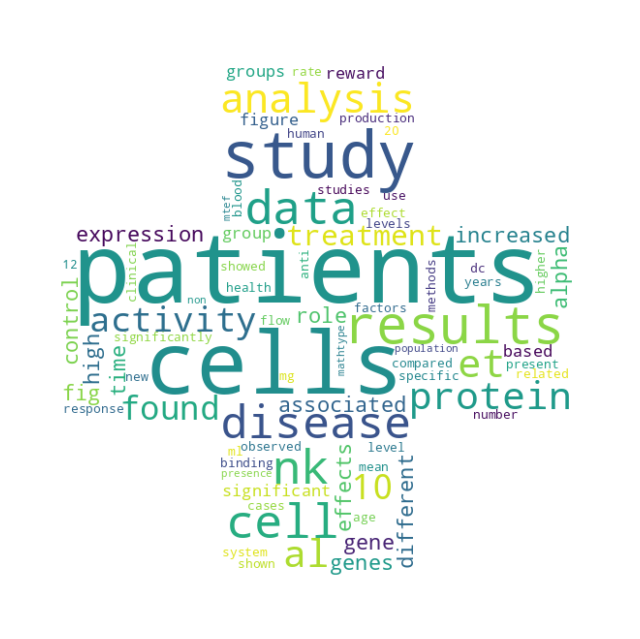

In [ ]:
word_freq_dict = dict(zip(word_df['Word'], word_df['Frequency']))

png_url = "https://i.ibb.co/NrTyKCn/127880568-icona-medica-dell-ospedale-della-croce-nera-isolato-su-priorit-bassa-bianca-primo-soccorso.jpg"
response = requests.get(png_url)
img = Image.open(io.BytesIO(response.content))
mask_map = np.array(img)

# Generate a word cloud
wordcloud = WordCloud(background_color='white',
                      contour_width=1,  # Adjust this value to make the contours visible
                      contour_color='white', mask=mask_map)
wordcloud.generate_from_frequencies(word_freq_dict)


# Display the word cloud using Matplotlib
fig = plt.figure(figsize=(8,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

# Validation set

In order to create a *validation set* we select randomly the 20% of the *training set*.

In [ ]:
# Calculate the number of indices to select (20% of the length of the original list)
num_indices_to_select = int(0.20 * len(raw_train))

# Use random.sample to select random indices without replacement
random.seed(42)
validation_indices = random.sample(range(len(raw_train)), num_indices_to_select)

In [ ]:
num_indices_to_select

563

In [ ]:
raw_valid = [raw_train[i] for i in validation_indices]
ner_valid = [ner_train[i] for i in validation_indices]

raw_train = [raw_train[i] for i in range(len(raw_train)) if i not in validation_indices]
ner_train = [ner_train[i] for i in range(len(ner_train)) if i not in validation_indices]

print("Length of validation set:", len(raw_valid))
print("Length of validation NER set:", len(ner_valid))
print("Length of updated training set:", len(raw_train))
print("Length of updated training NER set:", len(ner_train))

Length of validation set: 563
Length of validation NER set: 563
Length of updated training set: 2252
Length of updated training NER set: 2252


Now we are converting words into tokens with the *keras* built-in function *Tokenizer()*, we fit this object on our corpus
- With the method *texts_to_sequences()* we can convert each set into vectors, we store the results in the variables *train_sequences*, *test_sequences* and *valid_sequences*
- In *tag2idx* we are associating each tag to the corresponding *output label*
- In *idxtag* we have the opposite, we have as keys the *output labels* and as values we have the tag
- With list comprehension we are creating other lists that contains, for each sentences, the associated output label

In [ ]:
# integer encode sequences of words
token_tokenizer = Tokenizer()    # Automatically lowers tokens
token_tokenizer.fit_on_texts(raw_train + raw_test + raw_valid)
train_sequences = token_tokenizer.texts_to_sequences(raw_train)
test_sequences = token_tokenizer.texts_to_sequences(raw_test)
valid_sequences = token_tokenizer.texts_to_sequences(raw_valid)

tag2idx = { tag: idx for idx, tag in enumerate(output_labels) }
idx2tag = { idx: tag for tag, idx in tag2idx.items() }
ner_train_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_train]
ner_test_sequences  = [[tag2idx[tag] for tag in sentence] for sentence in ner_test ]
ner_valid_sequences = [[tag2idx[tag] for tag in sentence] for sentence in ner_valid]

In the *ner_train_sequences* we have a lot of 4 because it corresponds to the O tag.

In [ ]:
print(tag2idx)
print(idx2tag)
#we consider the first sentence of the train set
print(raw_train[0])
#we consider the associated labels
print(ner_train_sequences)

{'O': 0, 'I-Anatomical_system': 1, 'B-Tissue': 2, 'I-Multi-tissue_structure': 3, 'B-Organism_substance': 4, 'I-Tissue': 5, 'I-Pathological_formation': 6, 'B-Anatomical_system': 7, 'B-Immaterial_anatomical_entity': 8, 'I-Organ': 9, 'I-Organism_subdivision': 10, 'I-Immaterial_anatomical_entity': 11, 'I-Cell': 12, 'B-Organ': 13, 'B-Pathological_formation': 14, 'I-Organism_substance': 15, 'I-Developing_anatomical_structure': 16, 'B-Developing_anatomical_structure': 17, 'B-Organism_subdivision': 18, 'B-Cell': 19, 'B-Cellular_component': 20, 'B-Multi-tissue_structure': 21, 'I-Cellular_component': 22}
{0: 'O', 1: 'I-Anatomical_system', 2: 'B-Tissue', 3: 'I-Multi-tissue_structure', 4: 'B-Organism_substance', 5: 'I-Tissue', 6: 'I-Pathological_formation', 7: 'B-Anatomical_system', 8: 'B-Immaterial_anatomical_entity', 9: 'I-Organ', 10: 'I-Organism_subdivision', 11: 'I-Immaterial_anatomical_entity', 12: 'I-Cell', 13: 'B-Organ', 14: 'B-Pathological_formation', 15: 'I-Organism_substance', 16: 'I-Dev

In [ ]:
print(raw_test[0])
print(test_sequences[0])
for i in test_sequences[0]:
    print(f'{i} : {token_tokenizer.index_word[i]}')

['[', 'Histopathologic', 'examination', 'of', 'rectal', 'carcinoma', ']', '.']
[24, 9192, 1029, 4, 4577, 409, 25, 1]
24 : [
9192 : histopathologic
1029 : examination
4 : of
4577 : rectal
409 : carcinoma
25 : ]
1 : .


In [ ]:
vocabulary_size = len(token_tokenizer.word_counts)
print(vocabulary_size)

11811


In [ ]:
print(raw_train[0])
print(ner_train_sequences[0])
for i in ner_train_sequences[0]:
    print(f'{i} : {idx2tag[i]}')

['Ventricular', 'fibrillation', 'due', 'to', 'long', 'QT', 'syndrome', 'probably', 'caused', 'by', 'clindamycin', '.']
[21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
21 : B-Multi-tissue_structure
0 : O
0 : O
0 : O
0 : O
0 : O
0 : O
0 : O
0 : O
0 : O
0 : O
0 : O


Here we are identyfing the lenght of the sequences, we are saving the maximum lenght and the percentiles distribution.

In [ ]:
sequence_len = np.array([len(s) for s in train_sequences])
longest_sequence = sequence_len.max()
print(f'Longest sequence: {longest_sequence}')

print([(str(p) + '%', np.percentile(sequence_len, p)) for p in range(75,101, 5)])

Longest sequence: 334
[('75%', 34.0), ('80%', 37.0), ('85%', 41.0), ('90%', 46.0), ('95%', 57.0), ('100%', 334.0)]


**Padding**

Here we are setting all the inputs with the same dimension, each sentence is a vector of lenght 334. In the sentences with lenght less than 334 we fill the empty cells with 0.

In [ ]:
max_sequence_len = longest_sequence
X_train = pad_sequences(train_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=max_sequence_len, padding='post', truncating='post')
X_valid = pad_sequences(valid_sequences, maxlen=max_sequence_len, padding='post', truncating='post')

Y_train = pad_sequences(ner_train_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_test = pad_sequences(ner_test_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')
Y_valid = pad_sequences(ner_valid_sequences, maxlen=max_sequence_len, value=tag2idx['O'], padding='post', truncating='post')

#one-hot encoding
Y_train = to_categorical(Y_train, num_classes=len(output_labels), dtype='int32')
Y_test = to_categorical(Y_test, num_classes=len(output_labels), dtype='int32')
Y_valid = to_categorical(Y_valid, num_classes=len(output_labels), dtype='int32')

In [ ]:
print(X_train[0])
print(Y_train[0])

[1364 3121  180   10  431 1939  377 2231  603   17 3122    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
token_tokenizer.index_word[0] = '_PAD_'

Now we are converting *X_train* and *Y_train* into numpy arrays.

In [ ]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(2252, 334)
(2252, 334, 23)


# Feed forward

A **feedforward neural network** is an architecture in which the information flows from one layer to next one, from the input layer, through the hidden layer and to the output layer.

<center>
  <img src="https://afit-r.github.io/public/images/analytics/deep_learning/fig18_1.png" />
</center>

Our model has 3 layers:

- **Embedding layer (input layer)**: in this layer we are performing a *word embedding* procedure on our input. We are setting the *input dimension* that corresponds to the dimension of the vocabulary +1. Keep in mind that the vocabulary is the set of unique words in the corpus, we are adding one unit to it because we want to consider also tokens not present in the vocabulary. The *input lenght* parameter corresponds to the dimension of the longest sequence in the corpus. Recall that the aim of the *word embedding* is to represent each word with a vector. With the *embedding_dim* parameter we can specify the dimension of the vectors that represent each word. The larger the *embedding_dim parameter*, the greater the complexity of the model.
- **Dense layer (hidden layer)**: this is a fully connected layer with 50 nodes and the *ReLu* activation function.
- **Dense layer (output layer)**: this is the last layer of the model. Since we want to perform a classification with 23 labels, the output dimension is 23 and we use a *SoftMax* activation function.

With the method *.compile()* of the class *Sequential()* we can define the essential features of the model before its training:
- **Optimizer**: we defined *adam* optimizer that defines how the model's weights are updated. It is a variation of the *SDG* method that adjusts adaptively the learning rate in order to speeding up the convergence of the minimum.
- **Loss function**: since we are dealing with a multi label classification we consider the *categorical_crossentropy* function.
- **Metrics**: we are using as metrics to measure the performance of the model the *accuracy*. Recall that the *accuracy* represents the ratio of correct predictions to the total number of predictions.


## Model definition

In [ ]:
embedding_dim = 57

model = Sequential()
model.add(layers.Embedding(input_dim=vocabulary_size+1,
                           output_dim=embedding_dim,
                           input_length=longest_sequence,
                           ))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(23, activation='softmax'))
model.compile(optimizer='adam',
              #multiclass classification
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 334, 57)           673284    
                                                                 
 dense_2 (Dense)             (None, 334, 50)           2900      
                                                                 
 dense_3 (Dense)             (None, 334, 23)           1173      
                                                                 
Total params: 677,357
Trainable params: 677,357
Non-trainable params: 0
_________________________________________________________________


## Model fitting

Now we can finally fit the model by using the *.fit()* method. We are defining 20 *epochs*, an *epoch* is completed when a model is fitted to the whole train set. This means that we are fitting the model on the train set 20 times. We are also specifying the *batch_size* that is the dimension of the subset of the train set that we are processing at each iteration.

In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=20,
                    #I am showing the loading bar
                    verbose=True,
                    validation_data=(X_test, Y_test),
                    batch_size=32)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/20
71/71 [==============================] - 14s 164ms/step - loss: 2.4097 - accuracy: 0.9102 - val_loss: 0.7933 - val_accuracy: 0.9970
Epoch 2/20
71/71 [==============================] - 7s 95ms/step - loss: 0.1613 - accuracy: 0.9971 - val_loss: 0.0461 - val_accuracy: 0.9970
Epoch 3/20
71/71 [==============================] - 4s 63ms/step - loss: 0.0271 - accuracy: 0.9971 - val_loss: 0.0333 - val_accuracy: 0.9970
Epoch 4/20
71/71 [==============================] - 4s 58ms/step - loss: 0.0170 - accuracy: 0.9973 - val_loss: 0.0288 - val_accuracy: 0.9973
Epoch 5/20
71/71 [==============================] - 3s 38ms/step - loss: 0.0128 - accuracy: 0.9975 - val_loss: 0.0265 - val_accuracy: 0.9974
Epoch 6/20
71/71 [==============================] - 2s 26ms/step - loss: 0.0106 - accuracy: 0.9978 - val_loss: 0.0252 - val_accuracy: 0.9975
Epoch 7/20
71/71 [==============================] - 2s 23ms/step - loss: 0.0091 - accuracy: 0.9982 - val_loss: 0.0242 - val_accuracy: 0.9976
Epoch 8/20


Now we want to define some useful functions in order to plot the: **validation accuracy**, **validation loss**, **training accuracy** and **training loss**.

The function *plot_history_csv()* plots the graphs of accuracy and loss trends starting from a *.csv* containing the accuracy and loss values. We decided to store this values in a separated file in order to have a backup in the case in which some errors occur in the colab notebooks.

In [ ]:
def plot_history_csv(history_df):

    # we are creating a dictionary that we will convert into a dataframe
    data = {
        'Epoch': list(range(1, len(history_df['accuracy']) + 1)),
        'Training Accuracy': history_df['accuracy'],
        'Validation Accuracy': history_df['val_accuracy'],
        'Training Loss': history_df['loss'],
        'Validation Loss': history_df['val_loss']
    }
    df = pd.DataFrame(data)

    # container
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Training and Validation Loss', 'Training and Validation Accuracy'])

    # loss graph
    fig.add_trace(go.Scatter(x=df['Epoch'], y=df['Training Loss'], mode='lines+markers', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Epoch'], y=df['Validation Loss'], mode='lines+markers', name='Validation Loss'), row=1, col=1)

    # accuracy graph
    fig.add_trace(go.Scatter(x=df['Epoch'], y=df['Training Accuracy'], mode='lines+markers', name='Training Accuracy'), row=1, col=2)
    fig.add_trace(go.Scatter(x=df['Epoch'], y=df['Validation Accuracy'], mode='lines+markers', name='Validation Accuracy'), row=1, col=2)


    fig.update_yaxes(title_text='Loss', row=1, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=2)

    fig.update_layout(showlegend=True)
    fig.show()

In order to store the results in a *.csv* file we can run the following code after the training of the model.

In [ ]:
history_values = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
}

history_df = pd.DataFrame(history_values)

# we store the history in the following file
history_df.to_csv('history_ff.csv', index=False)

We can also save the model in the following way:

In [ ]:
model.save('Feed_Forward.h5')

## Graphical representation of the performance

In [ ]:
history_df = pd.read_csv('history_ff.csv')
plot_history_csv(history_df)

## Classification report

In [ ]:
def from_encode_to_literal_labels(y_true, y_pred, idx2tag):
    '''Transform sequences of encoded labels in sequences of string labels'''
    let_y_true = list()
    let_y_pred = list()
    for sent_idx in range(len(y_true)):
        let_sent_true = []
        let_sent_pred = []
        for token_idx in range(len(y_true[sent_idx])):
            let_sent_true.append(idx2tag[y_true[sent_idx][token_idx]])
            let_sent_pred.append(idx2tag[y_pred[sent_idx][token_idx]])
        let_y_true.append(let_sent_true)
        let_y_pred.append(let_sent_pred)

    return let_y_true, let_y_pred

def remove_seq_padding(X, y_true, y_pred, pad=0):
    """Remove padding predictions from list of sequences"""
    new_true = []
    new_pred = []
    for sent_idx in range(len(X)):
        true_sent = []
        pred_sent = []
        for tok_idx in range(len(X[sent_idx])):
            if X[sent_idx][tok_idx] != pad:
                true_sent.append(y_true[sent_idx][tok_idx])
                pred_sent.append(y_pred[sent_idx][tok_idx])
        new_true.append(true_sent)
        new_pred.append(pred_sent)
    return np.array(new_true), np.array(new_pred)

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test), ('Validation Set', X_valid, Y_valid)]
batch_size = 32
for title, X, Y in datasets:
    Y_pred = model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred, idx2tag)

    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

71/71 [==============================] - 0s 3ms/step


<ipython-input-50-5890972985ca>:29: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Training Set
                                 precision    recall  f1-score   support

              Anatomical_system      0.000     0.000     0.000        32
                           Cell      0.701     0.802     0.748       339
             Cellular_component      0.726     0.564     0.635        94
Developing_anatomical_structure      1.000     0.267     0.421        15
   Immaterial_anatomical_entity      0.000     0.000     0.000        22
         Multi-tissue_structure      0.512     0.662     0.578       311
                          Organ      0.628     0.804     0.705       168
           Organism_subdivision      0.692     0.880     0.775        92
             Organism_substance      0.759     0.833     0.795       144
         Pathological_formation      0.559     0.730     0.633       174
                         Tissue      0.356     0.409     0.381        88

                      micro avg      0.614     0.699     0.654      1479
                      macro avg     

In order to understand the classification report we must understand the concepts of **precision**, **recall**, **f1-score**.
- $\text{precision}: \frac{TP}{TP+FP}$
-$\text{recall}: \frac{TP}{TP+FN}$
-$\text{f1-score}$ harmonic mean of precision and recall

We have three indicators to measure the performance of the model:
- micro avg: calculates precision, recall, and F1-score by aggregating results from individual examples
- macro avg: calculates the average of metrics independently for each class and then takes the unweighted mean (withot considering class unbalance)
- weighted avg: calculates the weighted average of metrics, where the weight is the proportion of examples in each class relative to the total.

# BiLSTM

In this section we are implementing the **BiLSTM** model. In order to understand this model it is necessary to review some concepts about **RNN** and **LSTM** cell.
- **RNN (Recurrent Neural Netwok)**: architecture used when we are dealing with sequential data where a single data unit is influenced by the previous ones. In this models the output of a node becomes the input of the node itself. \\
The problem with **RNN** is that, especially when they are dealing with large dimension input, they forget the first inputs.
- **LSTM (Long Short Term Memory)**: this kind of architecture tries to address the issues of the **RNN** by introducing the *conveyor belt* a variable that memorises information about the previous layers of the architecture.

<center>
  <img src="https://www.researchgate.net/profile/Sayed-Rafay-Bin-Shah-2/publication/353371672/figure/fig1/AS:1088315499524096@1636486043257/Structure-of-the-LSTM-cell.png" width = 600 height = 450/>
</center>


As we can see from the Figure we have that the **LSTM** cell has 3 gates:
- Forget gate: we are applying a *sigmoid* activation function to the previous hidden state $h_{t-1}$ and the input $x_t$ in order to decide which information to keep. Then we are multypling this result with the previous cell state $C_{t-1}$.
- Input gate: we are applying to the input and the previous hidden state the *tangent hyperbolic* function and the *sigmoid* function in order to obtain a *candidate value* $\tilde{C}_t$. Subsequentially we are obtaining the cell state $C_t$ by combining the *candidate value* with the output of the forget gate.
- Output gate: at the end of the day we are applying the *tangent hyperbolic* function to the cell state $C_t$ and we are obtaining the *hidden state* $h_t$ of the **LSTM** cell by combining it with the input and the previous cell state.

In the **BiLSTM** architecture is composed by two **LSTMs** that take the input in the *forward* and *backward* direction both. In this way we are improving the context available to the algorithm by knowing the words that immediate follow and preced a word in a sentence.

<center>
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-25_at_8.54.27_PM.png" height = 300/>
</center>


## Model definition

First of all we define a function to create the **BiLSTM** model:

In [ ]:
def my_BiLSTM(vocabulary_size, seq_len, n_classes, hidden_cells=200,
                  embed_dim=100, drop=0.4, use_glove=False, glove_matrix=None):
    """Create a BiLSTM model using keras, given its parameters"""
    model = Sequential()
    if use_glove:
        model.add(Embedding(vocabulary_size, embed_dim,
                            weights=[glove_matrix], input_length=seq_len,
                            mask_zero=True, trainable=True))
    else:
        model.add(Embedding(vocabulary_size, embed_dim, input_length=seq_len,
                            mask_zero=True))
    #dropout layer
    model.add(Dropout(drop))

    #bidirectional layer
    model.add(Bidirectional(LSTM(hidden_cells, return_sequences=True,
                                 dropout=drop)))
    #output layer
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    model.summary()

    return model

## Word embedding: GloVe

Since machine learning models are not able to process text, we need to generate features from a text document. In order to have a mathematical representation of the words in a corpus we can rely on **vector space models**, we can represent each word in the corpus as a n-dimensional vector. \\
With **GloVe**, each word is represented as a n-dimensional vector that caputures its semantic and synctactic difference. While **CBOW** tries to predict the current word based on the surrounding words and **Skip-gram** tries to predict the context words given a target word, **GloVe** tries to capture the relationship between words based on how frequently they appear together.

In [ ]:
# Download GloVe file
!wget https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the downloaded file
!unzip glove.6B.zip

# Move the required file to the current directory
!mv glove.6B.100d.txt /content

--2023-12-19 09:59:48--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-19 09:59:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-12-19 10:02:27 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [ ]:
#Run only once
os.remove('/content/glove.6B.300d.txt')
os.remove('/content/glove.6B.200d.txt')
os.remove('/content/glove.6B.50d.txt')
os.remove('/content/glove.6B.zip')

In [ ]:
def load_glove_embedding_matrix(path, word_index, embed_dim):
    """Load Glove embeddings.

    More info here:
    https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
    """
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
token_tokenizer = Tokenizer()

In [ ]:
USE_GLOVE = True
glove_matrix=None
if USE_GLOVE:
    glove_embedding_path = os.path.join('/content/', 'glove.6B.100d.txt')
    embedding_dim = 100
    glove_matrix = load_glove_embedding_matrix(glove_embedding_path, token_tokenizer.word_index, embedding_dim)

Found 400000 word vectors.


We can check how many words are missing in *GloVe* pre-trained embeddings that we have downloaded before:

In [ ]:
def check_for_missing_words(embedding_matrix):
    # Find the indices of zero rows
    zero_rows = np.all(embedding_matrix == 0, axis=1)

    # Extract the words that have zero rows
    missing_words = [word for word, is_zero in zip(tokenizer.word_index.keys(), zero_rows) if is_zero]

    return missing_words

# Check for missing words in the embedding matrix
missing_words = check_for_missing_words(glove_emb_matrix)

print("Words not found in pre-trained embeddings:", missing_words)
print("Total words missing:", len(missing_words))

Words not found in pre-trained embeddings: []
Total words missing: 0


In [ ]:
model = my_BiLSTM(vocabulary_size+1, max_sequence_len, len(output_labels),
                                 use_glove=USE_GLOVE, glove_matrix=glove_matrix)

best_model_file = os.path.join('models','lstm-conll-best-model.h5')
checkpoint = ModelCheckpoint(
    best_model_file,
    save_weights_only=True,
    save_best_only=True
)

# early stopping if the difference in loss of two epochs is less than 0.01
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=1, mode="auto", restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 334, 100)          1181200   
                                                                 
 dropout (Dropout)           (None, 334, 100)          0         
                                                                 
 bidirectional (Bidirection  (None, 334, 400)          481600    
 al)                                                             
                                                                 
 dense (Dense)               (None, 334, 23)           9223      
                                                                 
Total params: 1672023 (6.38 MB)
Trainable params: 1672023 (6.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model fitting

In [ ]:
%%time
batch_size = 10
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          epochs=15,
          verbose=2,
          callbacks=[checkpoint, early_stopping_callback],
          validation_data=(X_valid, Y_valid)
         )

Epoch 1/15
226/226 - 37s - loss: 0.2564 - accuracy: 0.9582 - precision: 0.9697 - recall: 0.9362 - val_loss: 0.1592 - val_accuracy: 0.9626 - val_precision: 0.9789 - val_recall: 0.9550 - 37s/epoch - 163ms/step
Epoch 2/15
226/226 - 8s - loss: 0.1490 - accuracy: 0.9680 - precision: 0.9814 - recall: 0.9582 - val_loss: 0.1063 - val_accuracy: 0.9726 - val_precision: 0.9846 - val_recall: 0.9638 - 8s/epoch - 37ms/step
Epoch 3/15
226/226 - 6s - loss: 0.1203 - accuracy: 0.9719 - precision: 0.9833 - recall: 0.9625 - val_loss: 0.0892 - val_accuracy: 0.9761 - val_precision: 0.9856 - val_recall: 0.9673 - 6s/epoch - 27ms/step
Epoch 4/15
226/226 - 7s - loss: 0.0985 - accuracy: 0.9755 - precision: 0.9849 - recall: 0.9668 - val_loss: 0.0763 - val_accuracy: 0.9794 - val_precision: 0.9878 - val_recall: 0.9711 - 7s/epoch - 29ms/step
Epoch 5/15
226/226 - 5s - loss: 0.0835 - accuracy: 0.9780 - precision: 0.9858 - recall: 0.9713 - val_loss: 0.0701 - val_accuracy: 0.9804 - val_precision: 0.9884 - val_recall: 0.

In [ ]:
def print_model_memory_usage(batch_size, model):
    """Print memory usage of a model in MB given the batch size"""
    mbytes = get_model_memory_usage(batch_size, model)
    print(f'Model size: {mbytes} MB')

In [ ]:
print_model_memory_usage(batch_size, model)

Model size: 14.316 MB


In [ ]:
history_values = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy'],
}

history_df = pd.DataFrame(history_values)

# we store the history in the following file
history_df.to_csv('history_BiLSTM.csv', index=False)

In [ ]:
model.save('BiLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Graphical representation of the model

In [ ]:
history_df = pd.read_csv('history_BiLSTM.csv')
plot_history_csv(history_df)

## Classification report

In [ ]:
datasets = [('Training Set', X_train, Y_train), ('Test Set', X_test, Y_test), ('Validation Set', X_valid, Y_valid)]

for title, X, Y in datasets:
    Y_pred = model.predict(X, batch_size=batch_size)
    Y_pred = np.array(np.argmax(Y_pred, axis=-1))
    Y = np.array(np.argmax(Y, axis=-1))
    Y, Y_pred = remove_seq_padding(X, Y, Y_pred)
    let_y_true, let_y_pred = from_encode_to_literal_labels(Y, Y_pred, idx2tag)

    print(title)
    print(classification_report(let_y_true, let_y_pred, digits=3))
    print('\n')

226/226 [==============================] - 1s 6ms/step


<ipython-input-39-5890972985ca>:29: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Training Set
                                 precision    recall  f1-score   support

              Anatomical_system      0.750     0.750     0.750        32
                           Cell      0.834     0.876     0.855       339
             Cellular_component      0.651     0.596     0.622        94
Developing_anatomical_structure      0.833     0.667     0.741        15
   Immaterial_anatomical_entity      0.000     0.000     0.000        22
         Multi-tissue_structure      0.673     0.662     0.668       311
                          Organ      0.756     0.810     0.782       168
           Organism_subdivision      0.670     0.685     0.677        92
             Organism_substance      0.802     0.701     0.748       144
         Pathological_formation      0.723     0.718     0.720       174
                         Tissue      0.512     0.739     0.605        88

                      micro avg      0.725     0.732     0.729      1479
                      macro avg     

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                                 precision    recall  f1-score   support

              Anatomical_system      0.389     0.500     0.438        14
                           Cell      0.636     0.586     0.610       304
             Cellular_component      0.348     0.182     0.239        88
Developing_anatomical_structure      0.600     0.130     0.214        23
   Immaterial_anatomical_entity      0.000     0.000     0.000        30
         Multi-tissue_structure      0.365     0.324     0.343       247
                          Organ      0.606     0.673     0.637       162
           Organism_subdivision      0.500     0.429     0.462        56
             Organism_substance      0.642     0.721     0.680       122
         Pathological_formation      0.523     0.460     0.489       150
                         Tissue      0.330     0.533     0.408        60

                      micro avg      0.522     0.482     0.501      1256
                      macro avg      0.449     0.

In [ ]:
i = 5
sentence = X_test[i]
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_pred = y_pred[i]
y_true = np.argmax(Y_test, axis=-1)[i]
for idx in range(len(sentence)):
    print(f'{token_tokenizer.index_word[sentence[idx]]:15}  {idx2tag[y_true[idx]]:6} | {idx2tag[y_pred[idx]]}')


59/59 [==============================] - 1s 14ms/step
the              O      | O
number           O      | O
of               O      | O
lymph            B-Pathological_formation | B-Pathological_formation
node             I-Pathological_formation | I-Pathological_formation
metastases       I-Pathological_formation | I-Pathological_formation
and              O      | O
the              O      | O
total            O      | O
number           O      | O
of               O      | O
lymph            B-Multi-tissue_structure | B-Multi-tissue_structure
nodes            I-Multi-tissue_structure | I-Multi-tissue_structure
examined         O      | O
should           O      | O
be               O      | O
reported         O      | O
.                O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_            O      | O
_PAD_        

# BERT

Now we will implement the BERT model. It is a model created by Google that revolutioned the NLP, and we will use it for Named Entity Recognition. Its power is the fact that it captures bidirectional context information and it was pretrained. Actually, it uses the "transfer learning" to increase its performance, thank to a large amount of unlabelled data that were given to it.


In order to understand the BERT model we must review some concepts about: **encoders, decoders** and **transformers.**
## Encoders and decoders
The **encoder block** is composed with LSTM cells in which each cell updates its hidden state $h_t$ according to its input $x_t$ and the previous hidden states $h_{t-1}$. The output of the **encoder block** is passed as input for the **decoder block**. In this block the output at each time step is computed according to the output of the previous cell and the internal states ($h_{t}, C_{t}$).
The problem of this approach is the <font color='red'>information bottleneck</font>: the output of the **encoder** must represent the meaning of the whole sequence passed as input and with long sequences this task is hard. With the **attention mechanism** the encoder passes all the hidden states to the **decoder** but, at every element of the **decoder**. The **decoder** looks at the set of hidden states that received, determines a score for each hidden state and does not consider the ones with lowest score. With the **attention mechanism** we have that each cell of the **decoder** takes as input a function of the previous hidden states and outputs of the **decoder**, and also the context vector that represent a sort of weighted sum of all **encoders** hidden states.
<center>
<img align = "center" src = "https://miro.medium.com/v2/resize:fit:1100/format:webp/1*0aHodc667UfSyZj-UY8OQw.png" width = 600 img>
<center>





## Transformers
The important novelty of this architecture is that, with respect to the previouse seq-to-seq models, **transformers** do not rely on Recurrent Neural Networks. First of all, since we do not rely on RNN, we introduce the **positional encoding** that gives to each word took as input a relative position. This architecture introduce also the **multi-head attention** mechanism in which the model uses multiple set of attention weights in paralles. This caveat allows the model to capture different types of relationships and dependencies between words.

<center>
<img src = "https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" height = 500<img>
<center>

**BERT** is a powerful language model that learns to understand words in context. It uses a bidirectional approach to consider both the past and future words in a sentence.
The **BERT** model follows the *transfer learning* paradigm, it is pretrained on a large text corpus, enabling it to learn deep contextual representations.

In [ ]:
!pip install simpletransformers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from simpletransformers.ner import NERModel, NERArgs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In the two following chunk we create the dataset as it's needed by the model: we are creating train and test dataset organized in tokeinzed words with the corresponding label and the number of the sentence. This last attribute will be create with a function that will increase the 'sentence_id' attribute at each dot. We know it's not the perfect way to do this task but we had decided this cryterion.

In [ ]:
def dataset_bert(raw, ner):
  sentence_id = np.arange(len(raw))
  my_dict_1 = {}
  my_dict_2 = {}
  for i in sentence_id:
    my_dict_1[i] = raw[i]
    my_dict_2[i] = ner[i]

  word_dict= []
  ner_dict = []
  id = []
  for k in my_dict_1.keys():
    for i in range(len(my_dict_1[k])):
      id.append(k)
      word_dict.append(my_dict_1[k][i])
      ner_dict.append(my_dict_2[k][i])
  s1 = pd.DataFrame(id, columns = ['sentence_id'])
  s2 = pd.DataFrame(word_dict, columns = ['words'])
  s3 = pd.DataFrame(ner_dict, columns = ['labels'])
  dff = pd.concat((s1,s2,s3), axis = 1)
  return dff

df_trainbert = dataset_bert(raw_train, ner_train)
df_testbert = dataset_bert(raw_test, ner_test)


Now we set the arguments as the batch_size, the learning_rate, the epochs and the seed. In particular the learining rate is the one that we had to tune, because it was to high and we didn't manage to make the loss decrease in other ways.

In [ ]:
label = df_trainbert["labels"].unique().tolist()

args=NERArgs()
args.num_train_epochs = 15
args.learning_rate = 0.01
args.overwrite_output_dir = True
args.train_batch_size = 32
args.eval_batch_size = 32
args.manual_seed = 46

In [ ]:
BERT_model = NERModel('bert','bert-base-cased', labels = label, args = args)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Now let's train the model and verify it's performance on the test-set.

In [ ]:
train_result = BERT_model.train_model(train_data=df_trainbert, eval_data=df_testbert, acc=accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
result_test, model_outputs_test, pred_list_test=BERT_model.eval_model(df_testbert)
result_train, model_outputs_train, pred_list_train=BERT_model.eval_model(df_trainbert)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/126 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions, raw_outputs = BERT_model.predict([raw_test[1], raw_test[2]], split_on_space = False)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Here are the results: for the training part and test part. We show the loss, the precision, the recall and the f1_score.

In [ ]:
result_train

{'eval_loss': 0.0025601696256381595,
 'precision': 0.9867303609341825,
 'recall': 0.9909381663113006,
 'f1_score': 0.9888297872340425}

In [ ]:
result_test

{'eval_loss': 0.10881760727762224,
 'precision': 0.6378504672897196,
 'recall': 0.6546762589928058,
 'f1_score': 0.6461538461538463}

In [ ]:
from itertools import chain
flat_pred_train = list(chain.from_iterable(pred_list_train))
flat_pred_test = list(chain.from_iterable(pred_list_test))

In [ ]:
accuracy_train = accuracy_score(y_true=df_trainbert['labels'],y_pred=flat_pred_train)
accuracy_train

0.9432300116699399

In [ ]:
accuracy_test = accuracy_score(y_true=df_testbert['labels'],y_pred=flat_pred_test)
accuracy_test

0.9272262518570304

# Conclusion


Due to the fact that our aim was the Named Entity Recognition, we have implemented three models: the feed forward, the BiLSTM and the BERT. The first model is the simplest one: made up of input layer, output layer and some hidden layers. The second allow also bidirectionality in order to improve the context information and the third, in addition, take advantage from transfer learning.
If we want to interpret the results in a more precise way we should consider that the classes are unbalanced, so we should look at the wheighted avarage of the output. The results follow the expectation: a more complex model obtain better results, indeed the metrics obtained in the test set are:

in the feed forward

*   precision: 0.413
*   recall: 0.369
*   f1-score: 0.386

In the BiLSTM

*   precision: 0.506
*   recall: 0.482
*   f1-score: 0.487

and in the BERT:

*   precision: 0.634
*   recall: 0.671
*   f1-score: 0.652

If we want to inspect in a more precise way, we can see that the accuracy in the test set computed through the feed forward is near to one, probably thank to the large number of "O" tags.
The same can be said for the BiLSTM, for which the values are little smaller but still near to one. In addition, the accuracy for the Bert model is close to the 93%.